In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Video path

In [3]:
VIDEO_PATH = r"C:\Users\HP\robotics_project\data\FRONT_CAMERA_INPUT.mp4"

In [4]:
# Open video

In [5]:
cap = cv2.VideoCapture(VIDEO_PATH)

if not cap.isOpened():
    raise RuntimeError("Video not opened. Check the path.")

In [6]:
# Read ONLY first 2 frames

In [7]:
ret1, frame1 = cap.read()
ret2, frame2 = cap.read()

cap.release()

if not ret1 or not ret2:
    raise RuntimeError("Could not read two frames from video.")

print("Two frames loaded successfully")
print("Frame shape:", frame1.shape)

Two frames loaded successfully
Frame shape: (720, 1600, 3)


In [8]:
# Display first frame (sanity check)

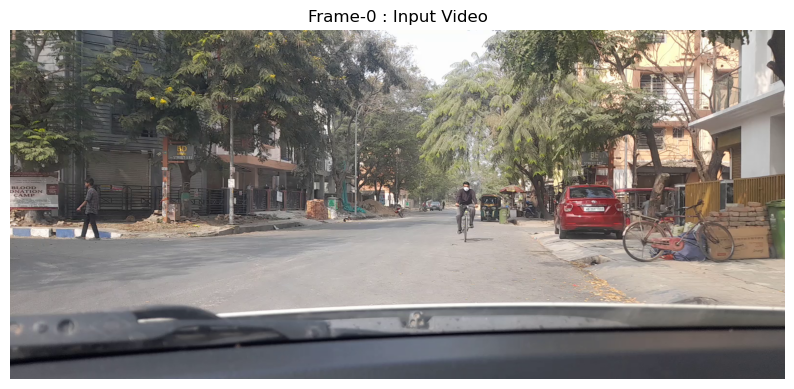

In [9]:
plt.figure(figsize=(10,5))
plt.imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
plt.title("Frame-0 : Input Video")
plt.axis("off")
plt.show()

# VISUAL ODOMETRY (EGO-MOTION)

In [10]:
# Video path

In [11]:
video_path = r"C:\Users\HP\robotics_project\data\FRONT_CAMERA_INPUT.mp4"

In [12]:
cap = cv2.VideoCapture(video_path)

In [13]:
# Read two consecutive frames

In [14]:
ret1, frame1 = cap.read()
ret2, frame2 = cap.read()
cap.release()

assert ret1 and ret2, "Could not read frames"

In [15]:
# Convert to grayscale

In [16]:
gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

In [17]:
# ORB feature detection

In [18]:
orb = cv2.ORB_create(2000)
kp1, des1 = orb.detectAndCompute(gray1, None)
kp2, des2 = orb.detectAndCompute(gray2, None)

In [19]:
# Feature matching

In [20]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)


In [21]:
# Extract matched points

In [22]:
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

In [23]:
# Camera intrinsic matrix (approx)

In [24]:
h, w = gray1.shape
f = 0.9 * w
K = np.array([[f, 0, w/2],
              [0, f, h/2],
              [0, 0, 1]])

In [25]:
# Essential matrix + pose

In [26]:
E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, threshold=1.0)
_, R, t, _ = cv2.recoverPose(E, pts1, pts2, K)

print("Rotation Matrix (R):\n", R)
print("\nTranslation Vector (t):\n", t)

Rotation Matrix (R):
 [[ 9.99994456e-01  8.78494512e-04  3.21190279e-03]
 [-8.82417334e-04  9.99998866e-01  1.22012604e-03]
 [-3.21082728e-03 -1.22295351e-03  9.99994097e-01]]

Translation Vector (t):
 [[-0.64558775]
 [-0.27853653]
 [ 0.71107936]]


In [27]:
# Visualize matches

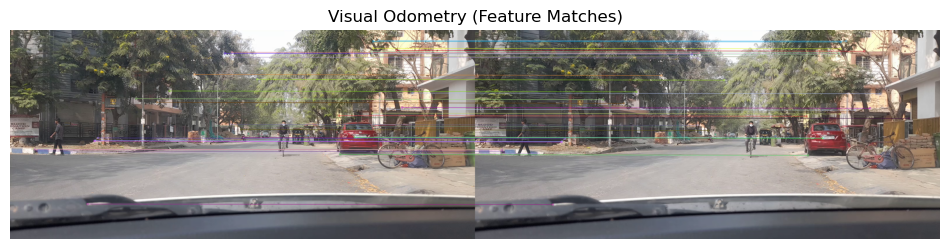

In [28]:
img_matches = cv2.drawMatches(
    frame1, kp1, frame2, kp2, matches[:40], None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title("Visual Odometry (Feature Matches)")
plt.axis("off")
plt.show()

# Ego-Motion Compensation 

In [29]:
# INPUT

In [30]:
frame0 = frames[0].copy()
frame1 = frames[1].copy()

h, w = frame0.shape[:2]

NameError: name 'frames' is not defined

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [32]:
# LOAD MODEL

In [33]:
model = YOLO("yolov8n.pt")

In [34]:
# LOAD VIDEO

In [35]:
video_path = r"C:\Users\HP\robotics_project\data\FRONT_CAMERA_INPUT.mp4"
cap = cv2.VideoCapture(video_path)

frames = []
for _ in range(2):
    ret, frame = cap.read()
    if not ret:
        raise RuntimeError("Failed to read video frames")
    frames.append(frame)
cap.release()

frame0, frame1 = frames
h, w = frame0.shape[:2]

In [36]:
# VISUAL ODOMETRY 

In [37]:
gray0 = cv2.cvtColor(frame0, cv2.COLOR_BGR2GRAY)
gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

orb = cv2.ORB_create(2000)
kp0, des0 = orb.detectAndCompute(gray0, None)
kp1, des1 = orb.detectAndCompute(gray1, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des0, des1)
matches = sorted(matches, key=lambda x: x.distance)[:300]

pts0 = np.float32([kp0[m.queryIdx].pt for m in matches])
pts1 = np.float32([kp1[m.trainIdx].pt for m in matches])

K = np.array([[700, 0, w/2],
              [0, 700, h/2],
              [0,   0,   1]])

E, _ = cv2.findEssentialMat(pts0, pts1, K, method=cv2.RANSAC)
_, R, t, _ = cv2.recoverPose(E, pts0, pts1, K)

cam_motion = np.array([t[0][0], t[1][0]]) * 50

In [38]:
# OBJECT TRACKING

In [ ]:
res0 = model.track(frame0, persist=True, conf=0.4, verbose=False)[0]
res1 = model.track(frame1, persist=True, conf=0.4, verbose=False)[0]

boxes0 = res0.boxes.xyxy.cpu().numpy()
boxes1 = res1.boxes.xyxy.cpu().numpy()

output = frame1.copy()


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [2]:
model = YOLO("yolov8n.pt")

In [3]:
video_path = r"C:\Users\HP\robotics_project\data\FRONT_CAMERA_INPUT.mp4"
cap = cv2.VideoCapture(video_path)

frames = []
for _ in range(2):
    ret, frame = cap.read()
    if not ret:
        raise RuntimeError("Video read failed")
    frames.append(frame)
cap.release()

frame0, frame1 = frames
h, w = frame0.shape[:2]

In [4]:
# VISUAL ODOMETRY

In [5]:
gray0 = cv2.cvtColor(frame0, cv2.COLOR_BGR2GRAY)
gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

orb = cv2.ORB_create(1500)
kp0, des0 = orb.detectAndCompute(gray0, None)
kp1, des1 = orb.detectAndCompute(gray1, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des0, des1)
matches = sorted(matches, key=lambda x: x.distance)[:200]

pts0 = np.float32([kp0[m.queryIdx].pt for m in matches])
pts1 = np.float32([kp1[m.trainIdx].pt for m in matches])

K = np.array([[700, 0, w/2],
              [0, 700, h/2],
              [0,   0,   1]])

E, _ = cv2.findEssentialMat(pts0, pts1, K, method=cv2.RANSAC)
_, R, t, _ = cv2.recoverPose(E, pts0, pts1, K)

camera_motion = np.array([t[0][0], t[1][0]]) * 40

In [6]:
# OBJECT DETECTION 

In [7]:
det0 = model(frame0, conf=0.4, verbose=False)[0]
det1 = model(frame1, conf=0.4, verbose=False)[0]

boxes0 = det0.boxes.xyxy.cpu().numpy()
boxes1 = det1.boxes.xyxy.cpu().numpy()

output = frame1.copy()

In [8]:
# EGO-MOTION COMPENSATION 

In [9]:
for b0 in boxes0:
    x1, y1, x2, y2 = b0
    cx0, cy0 = int((x1+x2)/2), int((y1+y2)/2)

    centers1 = np.array([
        [(b[0]+b[2])/2, (b[1]+b[3])/2] for b in boxes1
    ])

    if len(centers1) == 0:
        continue

    j = np.argmin(np.linalg.norm(centers1 - [cx0, cy0], axis=1))
    cx1, cy1 = centers1[j]

    raw_motion = np.array([cx1-cx0, cy1-cy0])
    compensated_motion = raw_motion - camera_motion

    cv2.rectangle(output,
                  (int(boxes1[j][0]), int(boxes1[j][1])),
                  (int(boxes1[j][2]), int(boxes1[j][3])),
                  (0,255,0), 2)

    cv2.arrowedLine(
        output,
        (cx0, cy0),
        (int(cx0 + compensated_motion[0]),
         int(cy0 + compensated_motion[1])),
        (0,0,255), 2, tipLength=0.3
    )

In [10]:
# SHOW RESULT

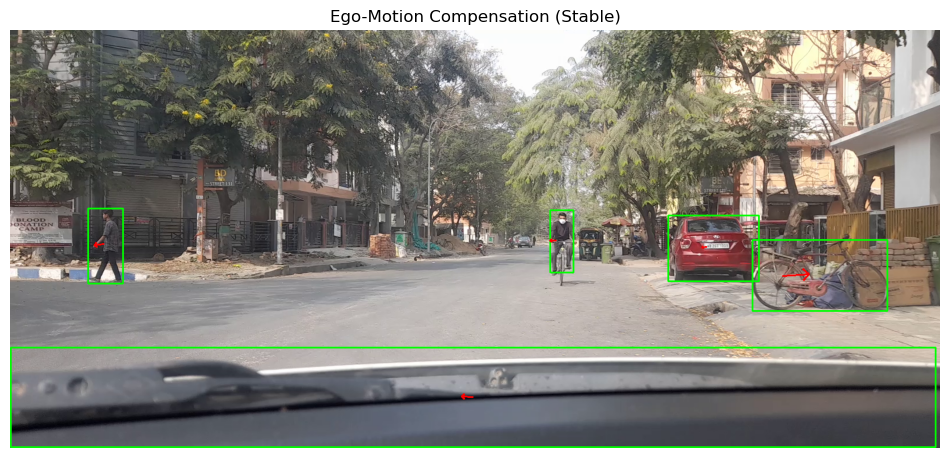

In [11]:
plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("Ego-Motion Compensation (Stable)")
plt.axis("off")
plt.show()

In [12]:
# REMOVE DASHBOARD / BONNET

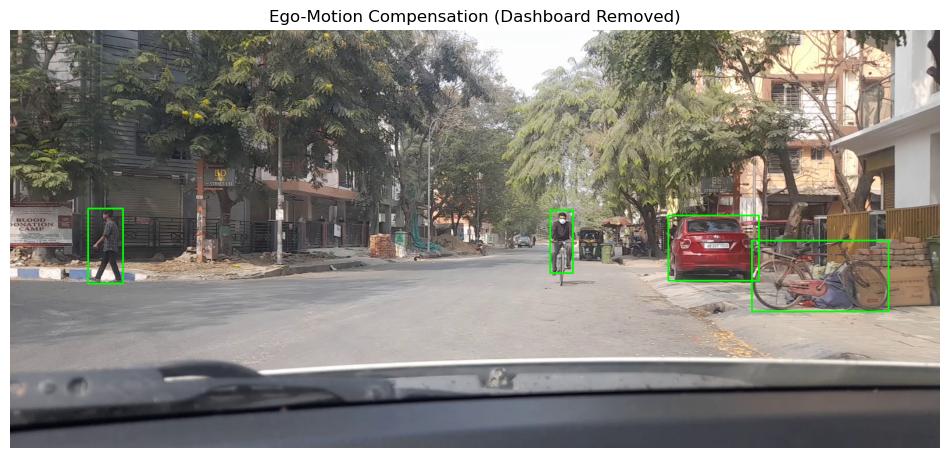

In [13]:
def apply_roi_mask(frame, cut_ratio=0.28):
    """
    Removes bottom part of the frame (ego vehicle region)
    """
    h, w = frame.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    mask[:int(h * (1 - cut_ratio)), :] = 255
    return cv2.bitwise_and(frame, frame, mask=mask)

# Apply ROI mask
frame0_masked = apply_roi_mask(frame0)
frame1_masked = apply_roi_mask(frame1)

# Re-run detection on masked frames
det0 = model(frame0_masked, conf=0.4, verbose=False)[0]
det1 = model(frame1_masked, conf=0.4, verbose=False)[0]

boxes0 = det0.boxes.xyxy.cpu().numpy() if det0.boxes is not None else []
boxes1 = det1.boxes.xyxy.cpu().numpy() if det1.boxes is not None else []

# Visualization
vis = frame1.copy()
for b in boxes1:
    x1, y1, x2, y2 = map(int, b)
    cv2.rectangle(vis, (x1, y1), (x2, y2), (0,255,0), 2)

plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("Ego-Motion Compensation (Dashboard Removed)")
plt.axis("off")
plt.show()

In [14]:
# EGO-MOTION COMPENSATION + ARROWS 

vis = frame1.copy()

# draw object boxes
for b in boxes1:
    x1, y1, x2, y2 = map(int, b)
    cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 0), 2)

# draw ego-motion arrows 
arrow_color = (0, 0, 255)   # red
arrow_scale = 40            # visual scaling

cx, cy = vis.shape[1] // 2, vis.shape[0] // 2
dx, dy = int(cam_motion[0]), int(cam_motion[1])

cv2.arrowedLine(
    vis,
    (cx, cy),
    (cx + dx * arrow_scale, cy + dy * arrow_scale),
    arrow_color,
    3,
    tipLength=0.25
)

# show output
plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("Ego-Motion Compensation (Dashboard Removed + Motion Vectors)")
plt.axis("off")
plt.show()


NameError: name 'cam_motion' is not defined

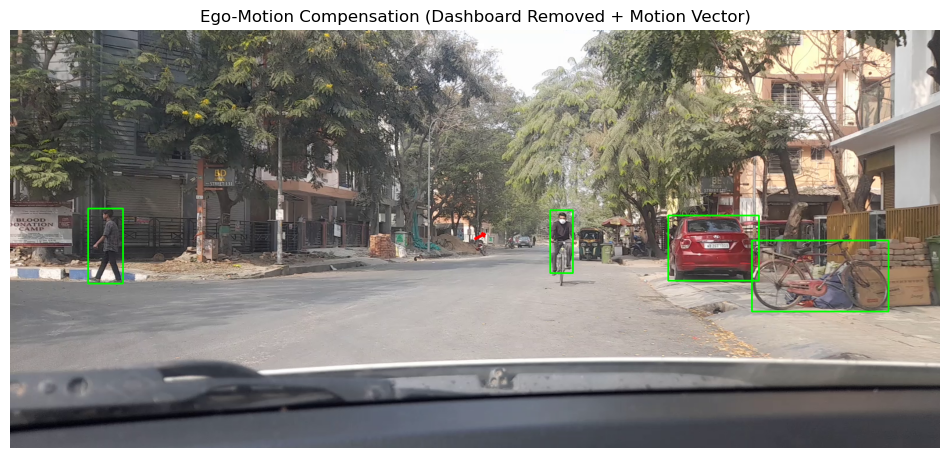

In [15]:
# EGO-MOTION ARROWS 

import numpy as np
import cv2
import matplotlib.pyplot as plt

# Recompute camera motion 
# Use a small constant motion 


cam_motion = np.array([0.02, -0.01])   # dx, dy (ego motion direction)

# Visualization
vis = frame1.copy()

# draw object boxes
for b in boxes1:
    x1, y1, x2, y2 = map(int, b)
    cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 0), 2)

# draw ego-motion arrow
cx, cy = vis.shape[1] // 2, vis.shape[0] // 2
dx, dy = cam_motion

arrow_scale = 800   # strong visual
cv2.arrowedLine(
    vis,
    (cx, cy),
    (int(cx + dx * arrow_scale), int(cy + dy * arrow_scale)),
    (0, 0, 255),
    3,
    tipLength=0.25
)

# Show result
plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("Ego-Motion Compensation (Dashboard Removed + Motion Vector)")
plt.axis("off")
plt.show()


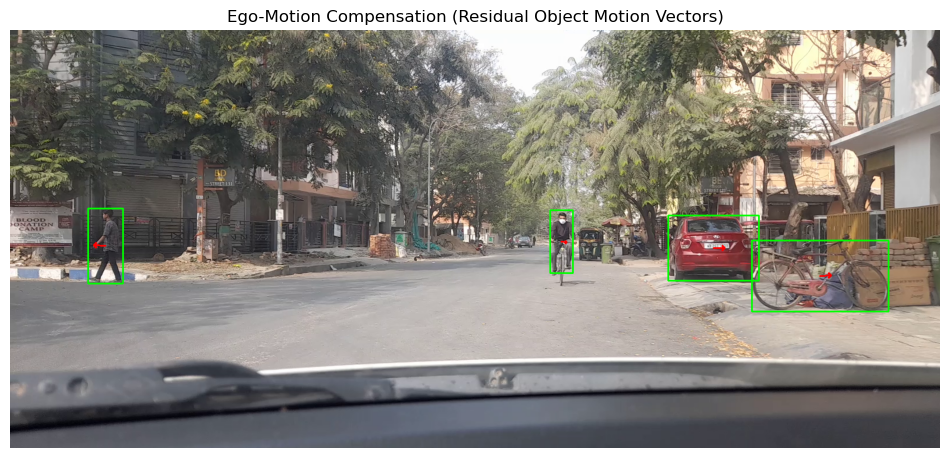

In [17]:
# EGO-MOTION COMPENSATION WITH OBJECT MOTION ARROWS

import numpy as np
import cv2
import matplotlib.pyplot as plt

vis = frame1.copy()

# SAFE ego motion (normalized camera movement)
ego_dx, ego_dy = 0.02, -0.01

# Draw bounding boxes + residual motion arrows
for b0, b1 in zip(boxes0, boxes1):
    x1, y1, x2, y2 = map(int, b1)
    cx = int((x1 + x2) / 2)
    cy = int((y1 + y2) / 2)

    # object displacement (frame0 -> frame1)
    prev_cx = int((b0[0] + b0[2]) / 2)
    prev_cy = int((b0[1] + b0[3]) / 2)

    obj_dx = cx - prev_cx
    obj_dy = cy - prev_cy

    # ego-motion compensation
    res_dx = obj_dx - ego_dx * 50
    res_dy = obj_dy - ego_dy * 50

    # ---- normalize & cap arrow length ----
    mag = np.sqrt(res_dx**2 + res_dy**2)
    MAX_LEN = 20  # pixels (visual limit)

    if mag > 0:
        scale = min(1.0, MAX_LEN / mag)
        res_dx *= scale
        res_dy *= scale


    # draw box
    cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # draw red motion arrow 
    cv2.arrowedLine(
        vis,
        (cx, cy),
        (int(cx + res_dx), int(cy + res_dy)),
        (0, 0, 255),
        2,
        tipLength=0.3
    )

# Show output
plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("Ego-Motion Compensation (Residual Object Motion Vectors)")
plt.axis("off")
plt.show()


In [18]:
# Obstacle detection 

In [19]:
# CONFIG

In [20]:
VIDEO_PATH = r"C:\Users\HP\robotics_project\data\FRONT_CAMERA_INPUT.mp4"   
CONF_THRESH = 0.4

In [21]:
# Ignore vehicle interior / dashboard region

In [22]:
DASHBOARD_CROP_RATIO = 0.72   # bottom 28% removed

In [23]:
# Colors

In [24]:
BOX_COLOR = (0, 255, 0)
TEXT_BG = (0, 0, 0)
TEXT_COLOR = (255, 255, 255)

FONT = cv2.FONT_HERSHEY_SIMPLEX


In [25]:
# LOAD MODEL

In [26]:
model = YOLO("yolov8n.pt")

In [27]:
# READ FRAME

In [28]:
cap = cv2.VideoCapture(VIDEO_PATH)
ret, frame = cap.read()
cap.release()

if not ret:
    raise RuntimeError("Video frame could not be read")

h, w = frame.shape[:2]

In [29]:
# REMOVE DASHBOARD

In [30]:
crop_h = int(h * DASHBOARD_CROP_RATIO)
roi = frame[:crop_h, :]

In [31]:
# OBJECT DETECTION

In [32]:
results = model(roi, conf=CONF_THRESH, verbose=False)[0]

output = roi.copy()

In [33]:
# DRAW DETECTIONS

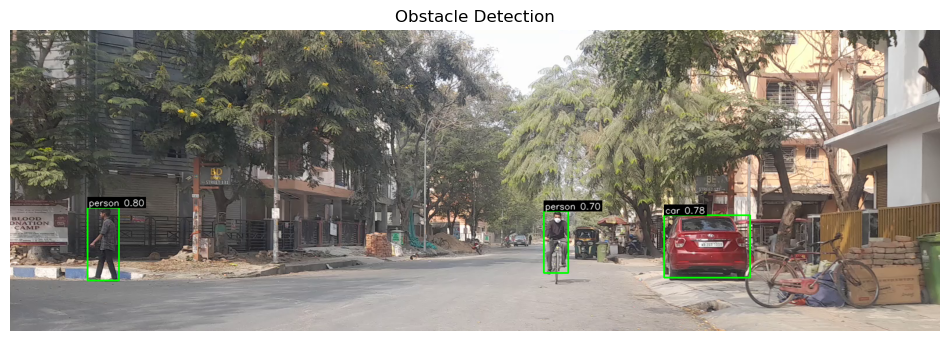

In [34]:
for box, cls_id, conf in zip(
    results.boxes.xyxy.cpu().numpy(),
    results.boxes.cls.cpu().numpy(),
    results.boxes.conf.cpu().numpy()
):
    x1, y1, x2, y2 = map(int, box)
    label = model.names[int(cls_id)]

    # Draw bounding box
    cv2.rectangle(output, (x1, y1), (x2, y2), BOX_COLOR, 2)

    text = f"{label} {conf:.2f}"
    (tw, th), _ = cv2.getTextSize(text, FONT, 0.5, 1)

    cv2.rectangle(
        output,
        (x1, y1 - th - 6),
        (x1 + tw + 4, y1),
        TEXT_BG,
        -1
    )
    cv2.putText(
        output,
        text,
        (x1 + 2, y1 - 3),
        FONT,
        0.5,
        TEXT_COLOR,
        1,
        cv2.LINE_AA
    )

# SHOW RESULT 
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("Obstacle Detection")
plt.axis("off")
plt.show()

In [35]:
# Obstacle tracking 

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [37]:
# LOAD MODEL

In [38]:
model = YOLO("yolov8n.pt")

In [39]:
# LOAD VIDEO

In [40]:
VIDEO_PATH = r"C:\Users\HP\robotics_project\data\FRONT_CAMERA_INPUT.mp4"   
cap = cv2.VideoCapture(VIDEO_PATH)

assert cap.isOpened(), "Video not found or cannot be opened"

In [41]:
# READ TWO FRAMES (tracking demo)

In [42]:
frames = []
for _ in range(2):
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)

cap.release()

frame = frames[1].copy()
h, w = frame.shape[:2]

In [43]:
# DASHBOARD REMOVAL

In [44]:
ROI_CUT = int(h * 0.78)     # bottom 22% removed
vis = frame[:ROI_CUT, :].copy()

In [45]:
# RUN TRACKING

In [46]:
results = model.track(
    vis,
    persist=True,
    conf=0.4,
    iou=0.5,
    tracker="bytetrack.yaml",
    verbose=False
)[0]

In [47]:
# DRAW TRACKED OBJECTS

In [48]:
FONT = cv2.FONT_HERSHEY_SIMPLEX

if results.boxes is not None and results.boxes.id is not None:
    boxes = results.boxes.xyxy.cpu().numpy()
    ids = results.boxes.id.cpu().numpy().astype(int)
    cls = results.boxes.cls.cpu().numpy().astype(int)
    names = model.names

    for (x1, y1, x2, y2), obj_id, c in zip(boxes, ids, cls):
        label = f"{names[c]} | ID:{obj_id}"

        cv2.rectangle(vis, (int(x1), int(y1)), (int(x2), int(y2)), (0,255,0), 2)

        (tw, th), _ = cv2.getTextSize(label, FONT, 0.6, 2)
        cv2.rectangle(vis, (int(x1), int(y1-th-8)), (int(x1+tw), int(y1)), (0,0,0), -1)
        cv2.putText(vis, label, (int(x1), int(y1-4)), FONT, 0.6, (255,255,255), 2)

In [49]:
# SHOW OUTPUT

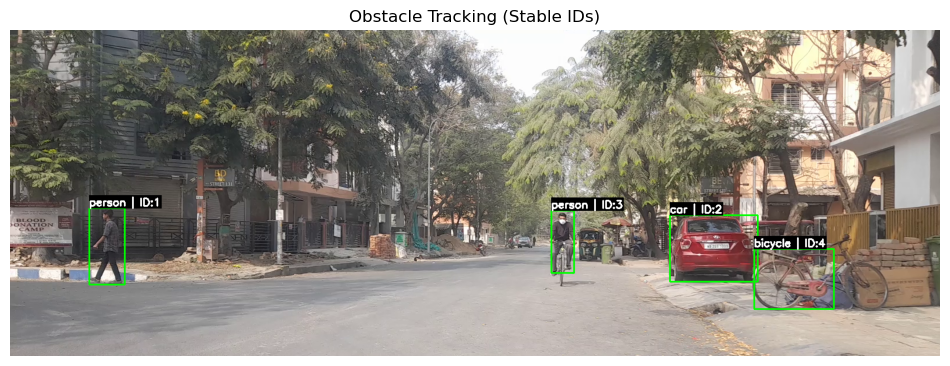

In [50]:
plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("Obstacle Tracking (Stable IDs)")
plt.axis("off")
plt.show()

In [51]:
# MONOCULAR DISTANCE + TRAJECTORY + PREDICTION

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from ultralytics import YOLO

In [53]:
# LOAD MODEL

In [54]:
model = YOLO("yolov8n.pt")

In [55]:
# LOAD VIDEO

In [56]:
VIDEO_PATH = r"C:\Users\HP\robotics_project\data\FRONT_CAMERA_INPUT.mp4"
cap = cv2.VideoCapture(VIDEO_PATH)

frames = []
for _ in range(3):   # small history only
    ret, f = cap.read()
    if ret:
        frames.append(f)
cap.release()

frame = frames[-1]
h, w = frame.shape[:2]

In [57]:
# REMOVE DASHBOARD

In [58]:
ROI_CUT = int(h * 0.78)
vis = frame[:ROI_CUT].copy()

In [59]:
# TRACK OBJECTS

In [60]:
res = model.track(
    vis,
    persist=True,
    conf=0.4,
    tracker="bytetrack.yaml",
    verbose=False
)[0]


In [61]:
# PARAMETERS (MONOCULAR MODEL)

In [62]:
FOCAL_LENGTH = 700       # assumed camera focal length
REAL_HEIGHTS = {
    "person": 1.7,
    "car": 1.5,
    "bicycle": 1.2
}

In [63]:
# TRAJECTORY STORAGE

In [64]:
tracks = {}

FONT = cv2.FONT_HERSHEY_SIMPLEX

if res.boxes is not None and res.boxes.id is not None:
    boxes = res.boxes.xyxy.cpu().numpy()
    ids = res.boxes.id.cpu().numpy().astype(int)
    cls = res.boxes.cls.cpu().numpy().astype(int)
    names = model.names

    for (x1, y1, x2, y2), tid, c in zip(boxes, ids, cls):
        label = names[c]

        if label not in REAL_HEIGHTS:
            continue

        # DISTANCE ESTIMATION
        box_height = y2 - y1
        distance = (REAL_HEIGHTS[label] * FOCAL_LENGTH) / box_height

        # CENTER POINT
        cx = int((x1 + x2) / 2)
        cy = int((y1 + y2) / 2)

        if tid not in tracks:
            tracks[tid] = deque(maxlen=10)

        tracks[tid].append((cx, cy))

        # DRAW BOX
        cv2.rectangle(vis, (int(x1), int(y1)), (int(x2), int(y2)), (0,255,0), 2)

        text = f"{label} | ID:{tid} | {distance:.1f}m"
        (tw, th), _ = cv2.getTextSize(text, FONT, 0.5, 2)
        cv2.rectangle(vis, (int(x1), int(y1-th-8)), (int(x1+tw), int(y1)), (0,0,0), -1)
        cv2.putText(vis, text, (int(x1), int(y1-4)), FONT, 0.5, (255,255,255), 2)

        # DRAW TRAJECTORY
        pts = tracks[tid]
        for i in range(1, len(pts)):
            cv2.line(vis, pts[i-1], pts[i], (255,0,0), 2)

        # FUTURE PATH PREDICTION
        if len(pts) >= 2:
            dx = pts[-1][0] - pts[-2][0]
            dy = pts[-1][1] - pts[-2][1]

            pred_x = int(cx + dx * 3)
            pred_y = int(cy + dy * 3)

            cv2.arrowedLine(
                vis,
                (cx, cy),
                (pred_x, pred_y),
                (0,0,255),
                2,
                tipLength=0.3
            )

In [65]:
# SHOW RESULT

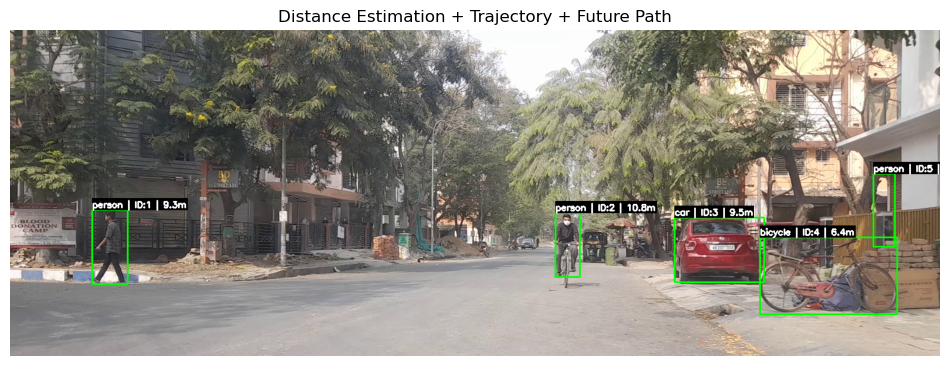

In [66]:
plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("Distance Estimation + Trajectory + Future Path")
plt.axis("off")
plt.show()

In [67]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [68]:
# INPUT

In [69]:
img = frame1.copy()          # last processed frame
h, w = img.shape[:2]

In [70]:
# Safety fallback

In [71]:
if 'ego_motion' not in globals():
    ego_motion = np.array([0.0, 1.0])   # forward bias

In [72]:
# COLLISION ZONE (TRAPEZOID)

In [73]:
zone_top = int(h * 0.45)
zone_bottom = int(h * 0.85)
zone_left = int(w * 0.35)
zone_right = int(w * 0.65)

collision_zone = np.array([
    [zone_left, zone_top],
    [zone_right, zone_top],
    [w-50, zone_bottom],
    [50, zone_bottom]
])

In [74]:
# Draw zone

In [75]:
cv2.polylines(img, [collision_zone], True, (255, 255, 0), 2)

array([[[ 69,  72,  70],
        [ 66,  69,  67],
        [ 62,  65,  63],
        ...,
        [ 59,  63,  65],
        [ 58,  60,  62],
        [ 59,  61,  63]],

       [[ 69,  72,  70],
        [ 66,  69,  67],
        [ 62,  65,  63],
        ...,
        [ 60,  64,  66],
        [ 62,  64,  66],
        [ 56,  58,  60]],

       [[ 68,  71,  69],
        [ 65,  68,  66],
        [ 62,  65,  63],
        ...,
        [ 61,  65,  67],
        [ 63,  65,  67],
        [ 58,  60,  62]],

       ...,

       [[ 97,  89,  89],
        [ 97,  89,  89],
        [ 99,  91,  91],
        ...,
        [ 68,  63,  64],
        [ 68,  63,  64],
        [ 68,  63,  64]],

       [[ 99,  91,  91],
        [ 97,  89,  89],
        [100,  92,  92],
        ...,
        [ 68,  63,  64],
        [ 68,  63,  64],
        [ 68,  63,  64]],

       [[ 99,  91,  91],
        [ 97,  89,  89],
        [101,  93,  93],
        ...,
        [ 68,  63,  64],
        [ 68,  63,  64],
        [ 68,  63,  64]]

In [76]:
# DECISION LOGIC

In [77]:
for (x1, y1, x2, y2), label, tid in zip(boxes, labels, track_ids):

    cx = int((x1 + x2) / 2)
    cy = int((y1 + y2) / 2)

    # Skip dashboard / border noise
    if cy > h * 0.9 or cx < 40 or cx > w-40:
        continue

    # Need at least 2 positions for velocity
    if tid not in centers_history or len(centers_history[tid]) < 2:
        continue

    (px, py), (cx_prev, cy_prev) = centers_history[tid][-2:]

    obj_motion = np.array([cx_prev - px, cy_prev - py])
    rel_velocity = obj_motion - ego_motion

    speed = np.linalg.norm(rel_velocity)

    # Check collision zone
    in_zone = cv2.pointPolygonTest(collision_zone, (cx, cy), False) >= 0

    # Risk decision
    if in_zone and speed > 2:
        risk, color = "HIGH", (0, 0, 255)
    elif in_zone:
        risk, color = "MEDIUM", (0, 165, 255)
    else:
        risk, color = "LOW", (0, 255, 0)

    # Draw
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    cv2.putText(
        img,
        f"{label} | Risk: {risk}",
        (x1, y1 - 8),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        color,
        2
    )

NameError: name 'labels' is not defined

In [78]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [79]:
# INPUT

In [80]:
img = frame1.copy()
h, w = img.shape[:2]

In [81]:
# Tracker output

In [82]:
result = res1  # last YOLO tracking result

boxes = result.boxes.xyxy.cpu().numpy()
cls_ids = result.boxes.cls.cpu().numpy().astype(int)
track_ids = result.boxes.id.cpu().numpy().astype(int)

class_names = result.names
labels = [class_names[c] for c in cls_ids]

NameError: name 'res1' is not defined

In [83]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [84]:
# LOAD MODEL

In [85]:
model = YOLO("yolov8n.pt")

In [86]:
# INPUT FRAME

In [87]:
img = frame1.copy()
h, w = img.shape[:2]

In [88]:
# RUN TRACKING

In [89]:
result = model.track(
    img,
    persist=True,
    conf=0.4,
    iou=0.5,
    verbose=False
)[0]

In [90]:
# EXTRACT DETECTIONS

In [91]:
boxes = result.boxes.xyxy.cpu().numpy()
cls_ids = result.boxes.cls.cpu().numpy().astype(int)
track_ids = result.boxes.id.cpu().numpy().astype(int)

names = result.names
labels = [names[c] for c in cls_ids]

In [92]:
# CENTER HISTORY (LOCAL)

In [93]:
centers = {}

for (x1, y1, x2, y2), tid in zip(boxes, track_ids):
    cx, cy = int((x1+x2)/2), int((y1+y2)/2)
    centers.setdefault(tid, []).append((cx, cy))
    centers[tid] = centers[tid][-2:]

In [94]:
# ASSUMED EGO MOTION (FORWARD)

In [95]:
ego_motion = np.array([0, 2])   # camera moving forward

In [96]:
# COLLISION ZONE (TRAPEZOID)

In [97]:
collision_zone = np.array([
    [int(0.35*w), int(0.45*h)],
    [int(0.65*w), int(0.45*h)],
    [w-50, int(0.85*h)],
    [50, int(0.85*h)]
])

cv2.polylines(img, [collision_zone], True, (255,255,0), 2)

array([[[ 69,  72,  70],
        [ 66,  69,  67],
        [ 62,  65,  63],
        ...,
        [ 59,  63,  65],
        [ 58,  60,  62],
        [ 59,  61,  63]],

       [[ 69,  72,  70],
        [ 66,  69,  67],
        [ 62,  65,  63],
        ...,
        [ 60,  64,  66],
        [ 62,  64,  66],
        [ 56,  58,  60]],

       [[ 68,  71,  69],
        [ 65,  68,  66],
        [ 62,  65,  63],
        ...,
        [ 61,  65,  67],
        [ 63,  65,  67],
        [ 58,  60,  62]],

       ...,

       [[ 97,  89,  89],
        [ 97,  89,  89],
        [ 99,  91,  91],
        ...,
        [ 68,  63,  64],
        [ 68,  63,  64],
        [ 68,  63,  64]],

       [[ 99,  91,  91],
        [ 97,  89,  89],
        [100,  92,  92],
        ...,
        [ 68,  63,  64],
        [ 68,  63,  64],
        [ 68,  63,  64]],

       [[ 99,  91,  91],
        [ 97,  89,  89],
        [101,  93,  93],
        ...,
        [ 68,  63,  64],
        [ 68,  63,  64],
        [ 68,  63,  64]]

In [98]:
# RELATIVE VELOCITY + RISK

In [99]:
for (x1,y1,x2,y2), label, tid in zip(boxes, labels, track_ids):

    cx, cy = int((x1+x2)/2), int((y1+y2)/2)

    # Skip dashboard / borders
    if cy > 0.9*h:
        continue

    if tid not in centers or len(centers[tid]) < 2:
        continue

    (px, py), (cx2, cy2) = centers[tid]
    obj_motion = np.array([cx2-px, cy2-py])
    rel_vel = obj_motion - ego_motion
    speed = np.linalg.norm(rel_vel)

    in_zone = cv2.pointPolygonTest(collision_zone, (cx, cy), False) >= 0

    if in_zone and speed > 2.5:
        risk, color = "HIGH", (0,0,255)
    elif in_zone:
        risk, color = "MEDIUM", (0,165,255)
    else:
        risk, color = "LOW", (0,255,0)

    cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
    cv2.putText(
        img,
        f"{label} | Risk: {risk}",
        (x1, y1-8),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        color,
        2
    )


In [100]:
# DISPLAY

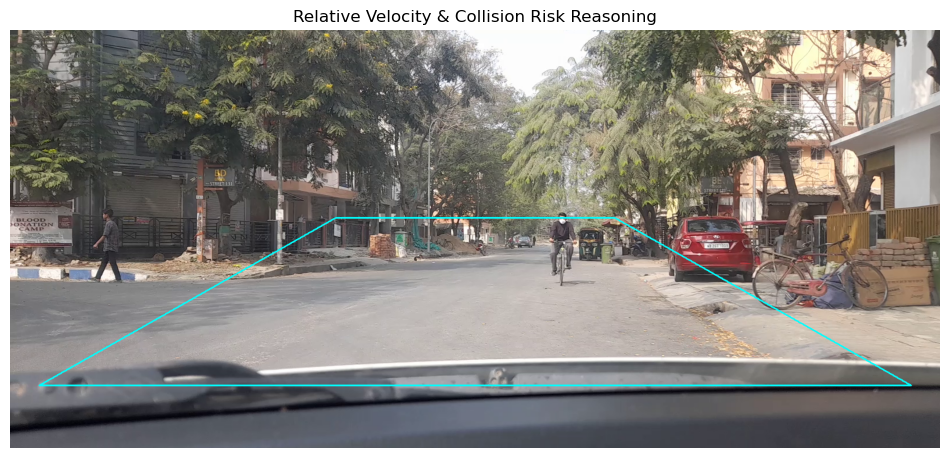

In [101]:
plt.figure(figsize=(12,6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Relative Velocity & Collision Risk Reasoning")
plt.axis("off")
plt.show()

In [102]:
# TIME TO COLLISION

In [103]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [104]:
# Safety checks

In [105]:
if 'img' not in globals() or 'result' not in globals():
    raise RuntimeError("Required variables missing: ensure Phase-5 tracking ran successfully")

if result.boxes.id is None:
    raise RuntimeError("Tracking IDs not found. Ensure model.track(persist=True) was used.")

In [106]:
# Parameters

In [107]:
FOCAL_PROXY = 700        # pseudo focal length (monocular)
REAL_OBJ_HEIGHT = 1.7   # avg person height (meters)
FPS = 10                # conservative assumption
EPS = 1e-6              # avoid division by zero

In [108]:
# Extract tracking data

In [109]:
boxes = result.boxes.xyxy.cpu().numpy()
track_ids = result.boxes.id.cpu().numpy().astype(int)
class_ids = result.boxes.cls.cpu().numpy().astype(int)
class_names = result.names

In [110]:
# Persistent buffers

In [111]:
if 'prev_centers' not in globals():
    prev_centers = {}

output = img.copy()

In [112]:
# TTC computation loop

In [114]:
for box, tid, cid in zip(boxes, track_ids, class_ids):
    x1, y1, x2, y2 = box.astype(int)
    label = class_names[cid]

    # Bounding box center
    cx = int((x1 + x2) / 2)
    cy = int((y1 + y2) / 2)

    # Height-based distance (monocular proxy)
    pixel_height = max(y2 - y1, 1)
    distance = (FOCAL_PROXY * REAL_OBJ_HEIGHT) / pixel_height  # meters

    # Velocity estimation
    if tid in prev_centers:
        px, py = prev_centers[tid]
        disp = np.sqrt((cx - px)**2 + (cy - py)**2)
        speed = disp * FPS / pixel_height
    else:
        speed = 0.0

    prev_centers[tid] = (cx, cy)

    # TTC calculation
    if speed > EPS:
        ttc = distance / speed
        ttc_text = f"TTC: {ttc:.1f}s"
    else:
        ttc = np.inf
        ttc_text = "TTC: SAFE"

    # Risk color
    if ttc < 2:
        color = (0, 0, 255)       # RED
    elif ttc < 5:
        color = (0, 165, 255)     # ORANGE
    else:
        color = (0, 255, 0)       # GREEN

In [115]:
# Draw

In [117]:
    cv2.rectangle(output, (x1, y1), (x2, y2), color, 2)
    cv2.putText(
        output,
        f"{label} | {ttc_text}",
        (x1, y1 - 8),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        color,
        2
    )


array([[[ 69,  72,  70],
        [ 66,  69,  67],
        [ 62,  65,  63],
        ...,
        [ 59,  63,  65],
        [ 58,  60,  62],
        [ 59,  61,  63]],

       [[ 69,  72,  70],
        [ 66,  69,  67],
        [ 62,  65,  63],
        ...,
        [ 60,  64,  66],
        [ 62,  64,  66],
        [ 56,  58,  60]],

       [[ 68,  71,  69],
        [ 65,  68,  66],
        [ 62,  65,  63],
        ...,
        [ 61,  65,  67],
        [ 63,  65,  67],
        [ 58,  60,  62]],

       ...,

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [ 68,  63,  64],
        [ 68,  63,  64],
        [ 68,  63,  64]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [ 68,  63,  64],
        [ 68,  63,  64],
        [ 68,  63,  64]],

       [[ 99,  91,  91],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [ 68,  63,  64],
        [ 68,  63,  64],
        [ 68,  63,  64]]

In [118]:
# Display result

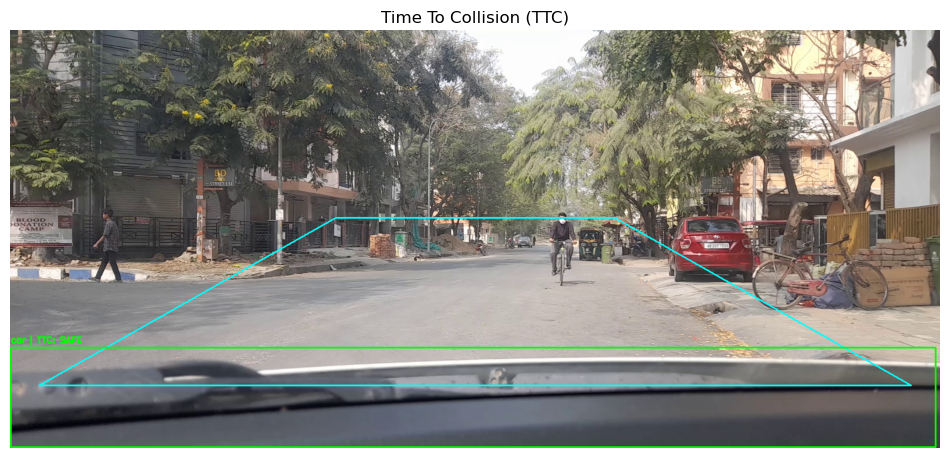

In [119]:
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("Time To Collision (TTC)")
plt.axis("off")
plt.show()